This notebook contains plots of various statistical and systems metrics gathered from the last run

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import visualization_utils
import math
import seaborn as sns
import numpy as np

In [2]:
from baseline_constants import (
    ACCURACY_KEY,
    BYTES_READ_KEY,
    BYTES_WRITTEN_KEY,
    CLIENT_ID_KEY,
    LOCAL_COMPUTATIONS_KEY,
    NUM_ROUND_KEY,
    NUM_SAMPLES_KEY)

def plot_accuracy_vs_round_number(realx_axis_values, 
                                  realy_axis_values,
                                  leafx_axis_values, 
                                  leafy_axis_values, 
                                  atype, 
                                  weighted=False, figsize=(10, 8), title_fontsize=16, **kwargs):

    plt.figure(figsize=figsize)
    title_weighted = 'Weighted' if weighted else 'Unweighted'
    plt.title(atype + ' Accuracy vs Round Number (%s)' % title_weighted, fontsize=title_fontsize)
    plt.plot(realx_axis_values, realy_axis_values, label='Testbed')
    plt.plot(leafx_axis_values, leafy_axis_values, label='LEAF')
    
    plt.legend(loc='center right')

    plt.ylabel('Accuracy')
    plt.xlabel('Round Number')
    plt.savefig('combined.png')

def get_accuracy_vs_round_number(stat_metrics, weighted=False):
    if weighted:
        accuracies = stat_metrics.groupby(NUM_ROUND_KEY).apply(_weighted_mean, ACCURACY_KEY, NUM_SAMPLES_KEY)
        accuracies = accuracies.reset_index(name=ACCURACY_KEY)

    else:
        accuracies = stat_metrics.groupby(NUM_ROUND_KEY, as_index=False).mean()
        stds = stat_metrics.groupby(NUM_ROUND_KEY, as_index=False).std()

    percentile_10 = stat_metrics.groupby(NUM_ROUND_KEY, as_index=False).apply(lambda x: x.quantile(0.10)) #.quantile(10)
    percentile_90 = stat_metrics.groupby(NUM_ROUND_KEY, as_index=False).apply(lambda x: x.quantile(0.90)) #.quantile(90)

#     print(accuracies)
    return accuracies, percentile_10, percentile_90

def get_training_time_vs_round_number(stat_metrics):
    training_times = stat_metrics.groupby(NUM_ROUND_KEY, as_index=False).mean()
    return training_times

def _weighted_mean(df, metric_name, weight_name):
    d = df[metric_name]
    w = df[weight_name]
    
    try:
        return (w * d).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

In [3]:
import seaborn as sns

## Quantifying training time under different RAM sizes

### Barplot using Seaborn

In [4]:
def get_data_to_barplot_slow_fast(pruning_percentage, mbps):
    fpath = f'system_heterogeneity/network/{mbps}/'
    SHOW_WEIGHTED = True # show weighted accuracy instead of unweighted accuracy
    PLOT_CLIENTS = True

    testbed_10k_5mbps = fpath + 'metrics_stat_testbed.csv' # change to None if desired
    testbed_10k_5mbps_pruned = fpath + 'metrics_stat_testbed_pruned.csv' # change to None if desired
    
    
    metrics_testbed_5mps = visualization_utils.load_data(testbed_10k_5mbps)
    metrics_testbed_5mps_pruned = visualization_utils.load_data(testbed_10k_5mbps_pruned)

    df_slow_device_5mpbs = metrics_testbed_5mps.loc[metrics_testbed_5mps['is_slow'] == 1]
    df_slow_device_5mpbs['prune_percentage'] = 'Slow Device (Large)'
    df_slow_device_5mpbs['device_type'] = "Slow Device"
    df_slow_device_5mpbs['speed'] = f'{mbps} Mbps'
    
    df_fast_device_5mpbs = metrics_testbed_5mps.loc[metrics_testbed_5mps['is_slow'] == 0]
    df_fast_device_5mpbs['device_type'] = "Fast Device"
    df_fast_device_5mpbs['prune_percentage'] = 'Fast Device (Large)'
    df_fast_device_5mpbs['speed'] = f'{mbps} Mbps'
    
    
    df_slow_device_5mpbs_pruned = metrics_testbed_5mps_pruned.loc[metrics_testbed_5mps_pruned['is_slow'] == 1]
    df_slow_device_5mpbs_pruned['prune_percentage'] = f'{pruning_percentage}% Pruned'
    df_slow_device_5mpbs_pruned['device_type'] = "Slow Device"
    df_slow_device_5mpbs_pruned['speed'] = f'{mbps} Mbps'
    
   
    panda_frames = []
    
    panda_frames.append(df_slow_device_5mpbs_pruned)
    combined_pruned_frame = pd.concat(panda_frames, axis=0, ignore_index=True)
    
    panda_frames = []

#     panda_frames.append(df_fast_device_80mpbs)
#     panda_frames.append(df_slow_device_80mpbs)
    panda_frames.append(df_fast_device_5mpbs)
    panda_frames.append(df_slow_device_5mpbs)
    

    combined_frame = pd.concat(panda_frames, axis=0, ignore_index=True)
    
    return combined_pruned_frame, combined_frame#data_to_plot, data_to_plot_pruned

In [10]:
combined_pruned_frame_1, combined_frame_1 = get_data_to_barplot_slow_fast(50, 1)
combined_pruned_frame_5, combined_frame_5 = get_data_to_barplot_slow_fast(50, 5)
combined_pruned_frame_10, combined_frame_10 = get_data_to_barplot_slow_fast(50, 10)
# combined_pruned_frame_50, combined_frame_50 = get_data_to_barplot_slow_fast(50, '14-10-2021')
# combined_pruned_frame_70, combined_frames_70 = get_data_to_barplot_slow_fast(70, '14-10-2021')

panda_frames_sf = []


panda_frames_sf.append(combined_frame_1)
panda_frames_sf.append(combined_pruned_frame_1)
panda_frames_sf.append(combined_frame_5)
panda_frames_sf.append(combined_pruned_frame_5)
panda_frames_sf.append(combined_frame_10)
panda_frames_sf.append(combined_pruned_frame_10)


combined_frame_sf = pd.concat(panda_frames_sf, axis=0, ignore_index=True)

/home/mustansar/Softwares/anaconda/envs/fedlearning/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/mustansar/Softwares/anaconda/envs/fedlearning/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/mustansar/Softwares/anaconda/envs/fedlearning/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy

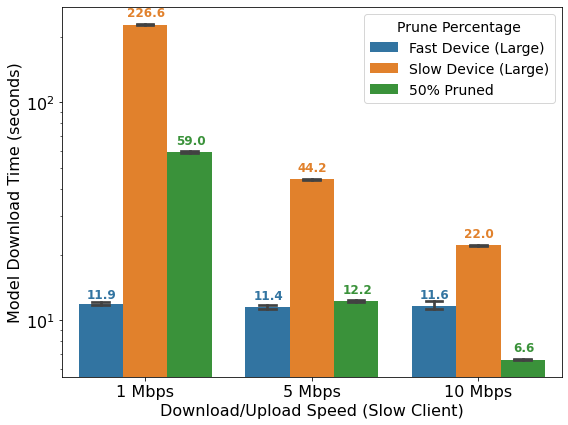

In [11]:
font_size = 16
#     sns.set_style({'font.family': font_family})
def plot_by_speed(dtype):
    fig, ax = plt.subplots(figsize=(8,6))


    # bar_plot = sns.barplot(x="prune_percentage",y="total_train_time",data=combined_frame_sf, hue="prune_percentage",capsize=0.1)
    bar_plot = sns.barplot(x="speed",y=dtype,data=combined_frame_sf, hue="prune_percentage",capsize=0.1)
    bar_plot.set_ylabel('Training Time in Milliseconds')
    bar_plot.set_xlabel('Model Parameters')          

    bar_plot.legend(title="Prune Percentage", fontsize=14, title_fontsize = 14, loc="best")

    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)
    plt.yscale('log')
    
    label = "Model Download"
    if dtype == "model_report_time":
        label = "Model Upload"
    
    ax.set_ylabel(f'{label} Time (seconds)', fontsize=font_size)
    ax.set_xlabel('Download/Upload Speed (Slow Client)', fontsize=font_size)

#     ax.set_ylim(0, 36)
    plt.tight_layout()

    for index, p in enumerate(bar_plot.patches):
        current_width = p.get_width()
        current_pos = p.get_x()
    #     print(type(p))

    #     if index == 0:
    #     p.set_x(current_pos+(current_width*2))
    #     bar_plot.axes.lines[index].set_xdata(current_pos+(current_width*2.5))
    #     print(bar_plot.axes.lines[index+1].get_xdata()) #[-0.37 -0.27]
    #     bar_plot.axes.lines[index+1].set_xdata([0.05, -0.05])
    #     bar_plot.axes.lines[2].set_xdata([0.05, -0.05])
        if dtype == 'model_download_time':
            if index == 0:
                bar_plot.annotate("{0:.1f}".format(p.get_height()),
                           (p.get_x() + p.get_width() / 2., p.get_height() ), 
                           ha = 'center', va = 'center', 
                           xytext = (1, 9), 
                           textcoords = 'offset points', color=p.get_facecolor(),weight='bold', size='large')    
            else:

                bar_plot.annotate("{0:.1f}".format(p.get_height()),
                           (p.get_x() + p.get_width() / 2., p.get_height() + p.get_height()*0.03), 
                           ha = 'center', va = 'center', 
                           xytext = (1, 9), 
                           textcoords = 'offset points', color=p.get_facecolor(),weight='bold', size='large')    
        else:
            if index == 0:
                bar_plot.annotate("{0:.1f}".format(p.get_height()),
                       (p.get_x() + p.get_width() / 2., p.get_height() + p.get_height()*0.04), 
                       ha = 'center', va = 'center', 
                       xytext = (1, 9), 
                       textcoords = 'offset points', color=p.get_facecolor(),weight='bold', size='large')    
            elif index == 2:

                bar_plot.annotate("{0:.1f}".format(p.get_height()),
                           (p.get_x() + p.get_width() / 2., p.get_height() + p.get_height()*0.28), 
                           ha = 'center', va = 'center', 
                           xytext = (1, 9), 
                           textcoords = 'offset points', color=p.get_facecolor(),weight='bold', size='large')    
            elif index == 1:

                bar_plot.annotate("{0:.1f}".format(p.get_height()),
                           (p.get_x() + p.get_width() / 2., p.get_height() + p.get_height()*0.1), 
                           ha = 'center', va = 'center', 
                           xytext = (1, 9), 
                           textcoords = 'offset points', color=p.get_facecolor(),weight='bold', size='large')    
            else:

                bar_plot.annotate("{0:.1f}".format(p.get_height()),
                           (p.get_x() + p.get_width() / 2., p.get_height() + p.get_height()*0.011), 
                           ha = 'center', va = 'center', 
                           xytext = (1, 9), 
                           textcoords = 'offset points', color=p.get_facecolor(),weight='bold', size='large')    
    

    plt.savefig(f'bar_plot_slow_fast_by_{dtype}.png')

plot_by_speed('model_download_time')

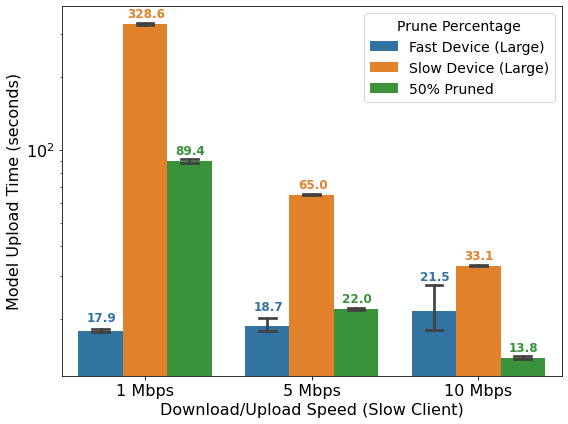

In [12]:
plot_by_speed('model_report_time')

In [15]:
accuracies = []


fpath = f'system_heterogeneity/network/'
fedavg_1 = fpath + '1/metrics_stat_testbed.csv'
hasaas_1_pruned = fpath + '1/metrics_stat_testbed_pruned.csv'

fedavg_5 = fpath + '5/metrics_stat_testbed.csv'
hasaas_5_pruned = fpath + '5/metrics_stat_testbed_pruned.csv'

fedavg_10 = fpath + '10/metrics_stat_testbed.csv'
hasaas_10_pruned = fpath + '10/metrics_stat_testbed_pruned.csv'

file_fedavg_1 = visualization_utils.load_data(fedavg_1)
file_hasaas_1_pruned = visualization_utils.load_data(hasaas_1_pruned)

file_fedavg_5 = visualization_utils.load_data(fedavg_5)
file_hasaas_5_pruned = visualization_utils.load_data(hasaas_5_pruned)

file_fedavg_10 = visualization_utils.load_data(fedavg_10)
file_hasaas_10_pruned = visualization_utils.load_data(hasaas_10_pruned)

accuracy_fedavg_1,_, _ = get_accuracy_vs_round_number(file_fedavg_1, True)
accuracy_hasaas_1_pruned,_, _ = get_accuracy_vs_round_number(file_hasaas_1_pruned, True)

accuracy_fedavg_5,_, _ = get_accuracy_vs_round_number(file_fedavg_5, True)
accuracy_hasaas_5_pruned,_, _ = get_accuracy_vs_round_number(file_hasaas_5_pruned, True)

accuracy_fedavg_10,_, _ = get_accuracy_vs_round_number(file_fedavg_10, True)
accuracy_hasaas_10_pruned,_, _ = get_accuracy_vs_round_number(file_hasaas_10_pruned, True)



In [14]:
fedavg_1gb_rows_until_20= file_fedavg_1gb.loc[(file_fedavg_1gb['is_slow'] == 1) & (file_fedavg_1gb['round_number'] <= 20)]
hasaas_1gb_pruned_rows_until_20= file_hasaas_1gb_pruned.loc[(file_hasaas_1gb_pruned['is_slow'] == 1) & (file_hasaas_1gb_pruned['round_number'] <= 20)]
fedavg_700mb_rows_until_20= file_fedavg_700mb.loc[(file_fedavg_700mb['is_slow'] == 1) & (file_fedavg_700mb['round_number'] <= 20)]
hasaas_700mb_pruned_rows_until_20= file_hasaas_700mb_pruned.loc[(file_hasaas_700mb_pruned['is_slow'] == 1) & (file_hasaas_700mb_pruned['round_number'] <= 20)]

fedavg_650mb_rows_until_20= file_fedavg_650mb.loc[(file_fedavg_650mb['is_slow'] == 1) & (file_fedavg_650mb['round_number'] <= 20)]

NameError: name 'file_fedavg_1gb' is not defined

In [37]:
x_coordinates = [] # Test Accuracy
y_coordinates = [] # Training Time
markers = []
labels = []

convergence_time_fedavg_1 = np.sum(((file_fedavg_1['round_completion_time']) / 60) / 60)

x_coordinates.append(accuracy_fedavg_1.iloc[-1]['accuracy'] * 100)
y_coordinates.append(convergence_time_fedavg_1)
markers.append("o")
labels.append("FedAvg (1 Mbps)")


convergence_time_fedavg_5 = np.sum(((file_fedavg_5['round_completion_time']) / 60) / 60)

x_coordinates.append(accuracy_fedavg_5.iloc[-1]['accuracy'] * 100)
y_coordinates.append(convergence_time_fedavg_5)
markers.append(">")
labels.append("FedAvg (5 Mbps)")


convergence_time_fedavg_10 = np.sum(((file_fedavg_10['round_completion_time']) / 60) / 60)

x_coordinates.append(accuracy_fedavg_10.iloc[-1]['accuracy'] * 100)
y_coordinates.append(convergence_time_fedavg_10)
markers.append("P")
labels.append("FedAvg (10 Mbps)")


convergence_time_hasaas_1_pruned = np.sum(((file_hasaas_1_pruned['round_completion_time']) / 60) / 60)

x_coordinates.append(accuracy_hasaas_1_pruned.iloc[-1]['accuracy'] * 100)
y_coordinates.append(convergence_time_hasaas_1_pruned)
markers.append("+")
labels.append("Hasaas (1 Mbps)")

convergence_time_hasaas_10_pruned = np.sum(((file_hasaas_10_pruned['round_completion_time']) / 60) / 60)


convergence_time_hasaas_5_pruned = np.sum(((file_hasaas_5_pruned['round_completion_time']) / 60) / 60)

x_coordinates.append(accuracy_hasaas_5_pruned.iloc[-1]['accuracy'] * 100)
y_coordinates.append(convergence_time_hasaas_10_pruned)
markers.append("*")
labels.append("Hasaas (5 Mbps)")


print("convergence_time_fedavg_1", convergence_time_fedavg_1, " convergence_time_hasaas_1_pruned", convergence_time_hasaas_1_pruned)


x_coordinates.append(accuracy_hasaas_10_pruned.iloc[-1]['accuracy'] * 100)
y_coordinates.append(convergence_time_hasaas_5_pruned)
markers.append("x")
labels.append("Hasaas (10 Mbps)")

convergence_time_fedavg_1 26.01777777777778  convergence_time_hasaas_1_pruned 7.788888888888889


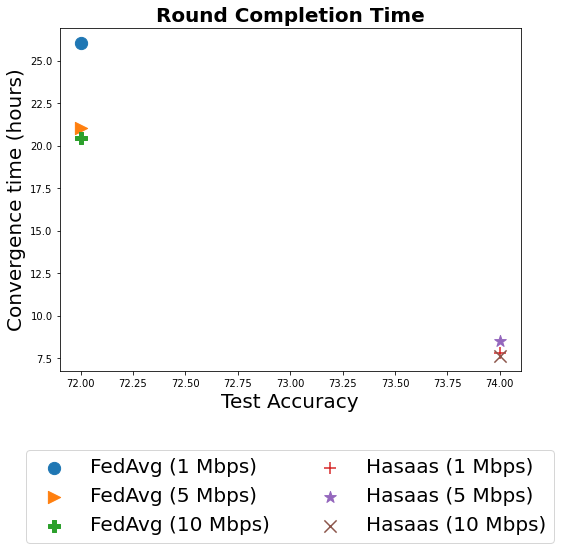

In [30]:
fig = plt.figure(figsize=(8,8))
#'FedAvg (4 Cores & Large)', 'FedAvg (4 Cores & 30%)', 'FedAvg (4 Cores & 50%)', 'FedAvg (4 Cores & 70%)'

fig.set_facecolor('white')
handles = []
for index, (xp, yp, m) in enumerate(zip(x_coordinates, y_coordinates, markers)):
    handle = plt.scatter(xp, yp, s=150, marker=m)
    handles.append(handle)
plt.xlabel("Test Accuracy", fontsize=20)
plt.ylabel("Convergence time (hours)", fontsize=20)
plt.title("Round Completion Time", fontsize=20, fontweight='bold')
    
plt.legend(handles = handles , labels=labels,loc='upper center', ncol=2, bbox_to_anchor=(0.5, -0.2),fancybox=True, shadow=False, fontsize=20)
plt.tight_layout()
# plt.show()
plt.savefig("fedavg_hasaas_convergence_time_network.png", transparent=False)

In [31]:
print(x_coordinates) 
print(y_coordinates)

[72.0, 72.0, 72.0, 74.0, 74.0, 74.0]
[26.01777777777778, 21.01888888888889, 20.418888888888887, 7.788888888888889, 8.48, 7.647777777777778]


In [32]:
combined_frame_sf.head(1)

,client_id,round_number,hierarchy,num_samples,set,accuracy,loss,model_size,avg_epoch_time,total_train_time,...,round_completion_time,trained_epochs,model_download_time,model_report_time,model_download_size,model_report_size,device_type,prune_percentage,speed,network_time
0,601a71a0-6535-4f3c-95a7-0c63ba13ea06_1,1,,250,test,0.0,None,26415307,46865,468651,...,2490,10,11.241,18.034,25,34,Fast Device,Fast Device (Large),1 Mbps,29.275


In [33]:
combined_frame_sf['network_time'] = combined_frame_sf['model_download_time'] + combined_frame_sf['model_report_time']

In [34]:
combined_frame_sf.head(1)

,client_id,round_number,hierarchy,num_samples,set,accuracy,loss,model_size,avg_epoch_time,total_train_time,...,round_completion_time,trained_epochs,model_download_time,model_report_time,model_download_size,model_report_size,device_type,prune_percentage,speed,network_time
0,601a71a0-6535-4f3c-95a7-0c63ba13ea06_1,1,,250,test,0.0,None,26415307,46865,468651,...,2490,10,11.241,18.034,25,34,Fast Device,Fast Device (Large),1 Mbps,29.275


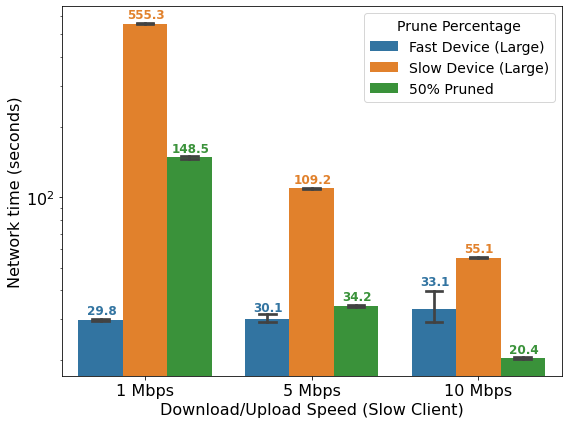

In [36]:
font_size = 16
#     sns.set_style({'font.family': font_family})
def plot_by_speed(dtype):
    fig, ax = plt.subplots(figsize=(8,6))


    # bar_plot = sns.barplot(x="prune_percentage",y="total_train_time",data=combined_frame_sf, hue="prune_percentage",capsize=0.1)
    bar_plot = sns.barplot(x="speed",y='network_time',data=combined_frame_sf, hue="prune_percentage",capsize=0.1)
    bar_plot.set_ylabel('Training Time in Milliseconds')
    bar_plot.set_xlabel('Model Parameters')          

    bar_plot.legend(title="Prune Percentage", fontsize=14, title_fontsize = 14, loc="best")

    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)
    plt.yscale('log')
    
    label = "Network time"
    
    ax.set_ylabel(f'Network time (seconds)', fontsize=font_size)
    ax.set_xlabel('Download/Upload Speed (Slow Client)', fontsize=font_size)

    plt.tight_layout()
    
    for index, p in enumerate(bar_plot.patches):
        current_width = p.get_width()
        current_pos = p.get_x()
    #     print(type(p))

        if index == 1:
            bar_plot.annotate("{0:.1f}".format(p.get_height()),
                       (p.get_x() + p.get_width() / 2., p.get_height()  + p.get_height()*0.02), 
                       ha = 'center', va = 'center', 
                       xytext = (1, 9), 
                       textcoords = 'offset points', color=p.get_facecolor(),weight='bold', size='large')    
        elif index == 2:
            bar_plot.annotate("{0:.1f}".format(p.get_height()),
                       (p.get_x() + p.get_width() / 2., p.get_height()  + p.get_height()*0.2), 
                       ha = 'center', va = 'center', 
                       xytext = (1, 9), 
                       textcoords = 'offset points', color=p.get_facecolor(),weight='bold', size='large')    
        else:
            bar_plot.annotate("{0:.1f}".format(p.get_height()),
                       (p.get_x() + p.get_width() / 2., p.get_height() ), 
                       ha = 'center', va = 'center', 
                       xytext = (1, 9), 
                       textcoords = 'offset points', color=p.get_facecolor(),weight='bold', size='large')    

    plt.savefig(f'bar_plot_slow_fast_by_network_time.png')

plot_by_speed('')

In [ ]:
convergence_time_hasaas_1_pruned = np.sum(((file_hasaas_1_pruned['round_completion_time']) / 60) / 60)
training_time = convergence_time_hasaas_1_pruned - 